# **3.1**

**Flatness v.s. Generalization**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  

def create_model(lr=1e-3):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [ ]:
def interpolate_models(model1, model2, alpha):
    interpolated_weights = []
    weights1 = model1.get_weights()
    weights2 = model2.get_weights()
    for w1, w2 in zip(weights1, weights2):
        interpolated_weights.append((1 - alpha) * w1 + alpha * w2)
    model = create_model()  
    model.set_weights(interpolated_weights)
    return model

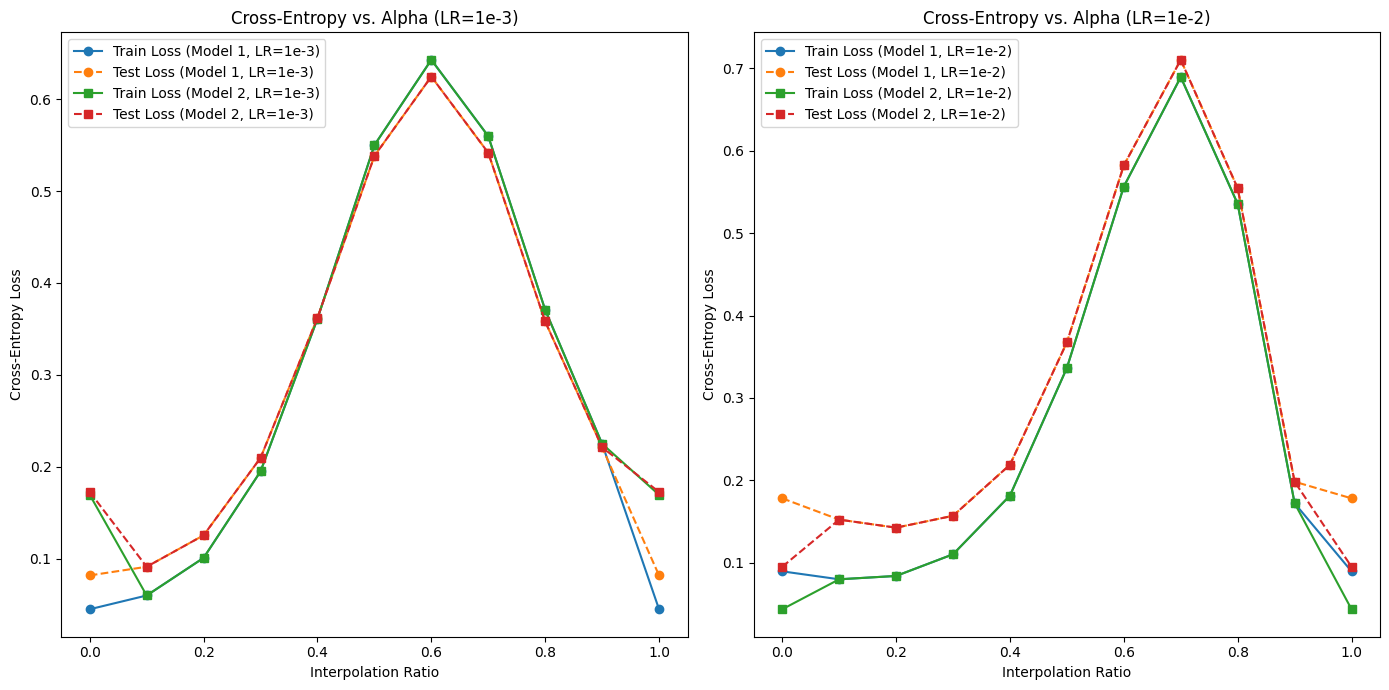

In [ ]:
def evaluate_interpolated_models(lr, batch_size1, batch_size2, x_train, y_train, x_test, y_test):

    model1 = create_model(lr=lr)
    model1.fit(x_train, y_train, epochs=5, batch_size=batch_size1, verbose=0)
    model2 = create_model(lr=lr)
    model2.fit(x_train, y_train, epochs=5, batch_size=batch_size2, verbose=0)

 
    model1_train_loss = model1.evaluate(x_train, y_train, verbose=0)[0]
    model1_test_loss = model1.evaluate(x_test, y_test, verbose=0)[0]
    model2_train_loss = model2.evaluate(x_train, y_train, verbose=0)[0]
    model2_test_loss = model2.evaluate(x_test, y_test, verbose=0)[0]
    alphas = np.linspace(0, 1, 11)
    train_losses_model1 = [model1_train_loss]
    test_losses_model1 = [model1_test_loss]
    train_losses_model2 = [model2_train_loss]
    test_losses_model2 = [model2_test_loss]

    for alpha in alphas[1:-1]:
        model = interpolate_models(model1, model2, alpha)
        train_loss = model.evaluate(x_train, y_train, verbose=0)[0]
        test_loss = model.evaluate(x_test, y_test, verbose=0)[0]
        train_losses_model1.append(train_loss)
        test_losses_model1.append(test_loss)
        train_losses_model2.append(train_loss)
        test_losses_model2.append(test_loss)

    train_losses_model1.append(model1_train_loss)
    test_losses_model1.append(model1_test_loss)
    train_losses_model2.append(model2_train_loss)
    test_losses_model2.append(model2_test_loss)

    return alphas, train_losses_model1, test_losses_model1, train_losses_model2, test_losses_model2

plt.figure(figsize=(14, 7))

# Evaluate and plot for learning rate 1e-3
alphas, train_losses_1e_3_model1, test_losses_1e_3_model1, train_losses_1e_3_model2, test_losses_1e_3_model2 = evaluate_interpolated_models(1e-3, 64, 1024, x_train, y_train, x_test, y_test)
plt.subplot(1, 2, 1)
plt.plot(alphas, train_losses_1e_3_model1, 'o-', label='Train Loss (Model 1, LR=1e-3)')
plt.plot(alphas, test_losses_1e_3_model1, 'o--', label='Test Loss (Model 1, LR=1e-3)')
plt.plot(alphas, train_losses_1e_3_model2, 's-', label='Train Loss (Model 2, LR=1e-3)')
plt.plot(alphas, test_losses_1e_3_model2, 's--', label='Test Loss (Model 2, LR=1e-3)')
plt.xlabel('Interpolation Ratio')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy vs. Alpha (LR=1e-3)')
plt.legend()

# Evaluate and plot for learning rate 1e-2
alphas, train_losses_1e_2_model1, test_losses_1e_2_model1, train_losses_1e_2_model2, test_losses_1e_2_model2 = evaluate_interpolated_models(1e-2, 64, 1024, x_train, y_train, x_test, y_test)
plt.subplot(1, 2, 2)
plt.plot(alphas, train_losses_1e_2_model1, 'o-', label='Train Loss (Model 1, LR=1e-2)')
plt.plot(alphas, test_losses_1e_2_model1, 'o--', label='Test Loss (Model 1, LR=1e-2)')
plt.plot(alphas, train_losses_1e_2_model2, 's-', label='Train Loss (Model 2, LR=1e-2)')
plt.plot(alphas, test_losses_1e_2_model2, 's--', label='Test Loss (Model 2, LR=1e-2)')
plt.xlabel('Interpolation Ratio')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy vs. Alpha (LR=1e-2)')
plt.legend()

plt.tight_layout()
plt.show()


**Sensitivity**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow.keras.backend as K

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 

def create_model(lr=1e-3):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [ ]:
# Function to calculate sensitivity (Frobenius norm of gradients)
def sensitivity(model, x, y):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

    x_tensor += np.random.normal(0, 0.1, x_tensor.shape)

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor)
        loss = SparseCategoricalCrossentropy()(y_tensor, predictions)

    gradients = tape.gradient(loss, x_tensor)
    return np.linalg.norm(gradients.numpy())

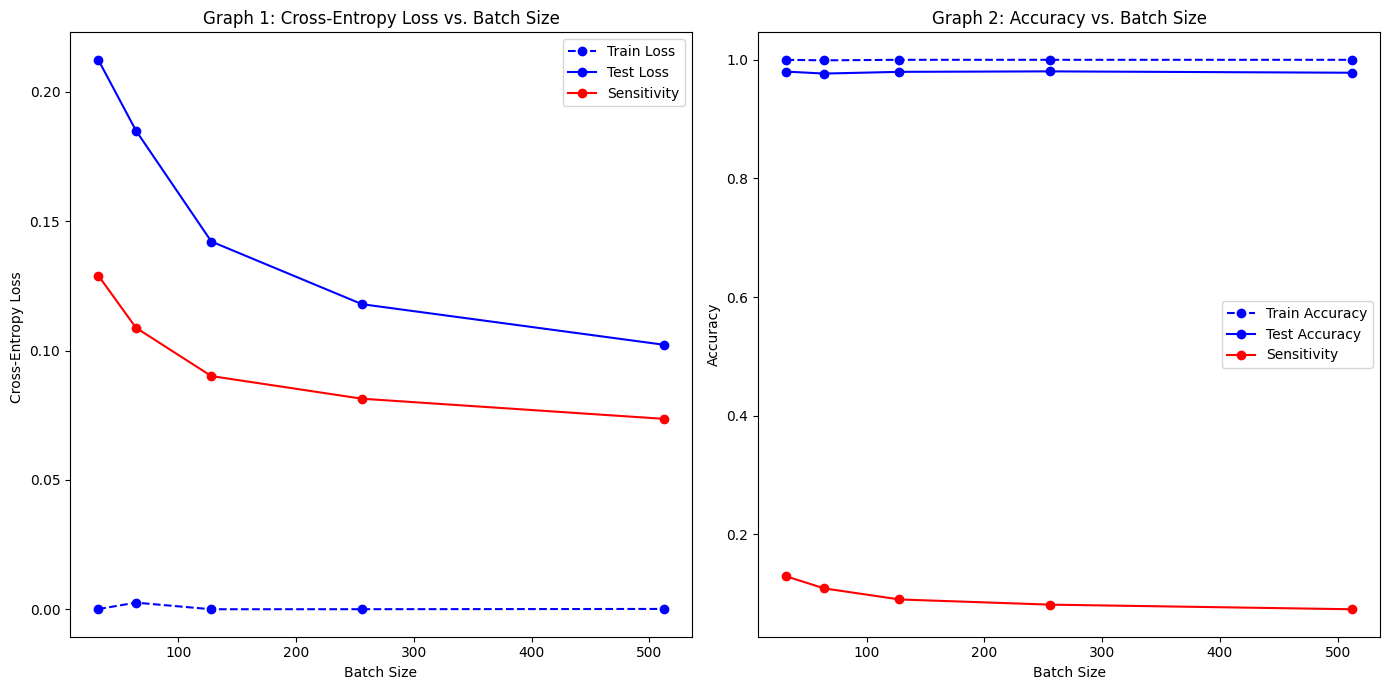

In [ ]:

batch_sizes = [32, 64, 128, 256, 512]
models = []
results = []

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, validation_data=(x_test, y_test), verbose=0)
    models.append(model)

    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    sensitivity_train = sensitivity(model, x_train, y_train)
    sensitivity_test = sensitivity(model, x_test, y_test)

    results.append({
        'batch_size': batch_size,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'sensitivity_train': sensitivity_train,
        'sensitivity_test': sensitivity_test
    })


plt.figure(figsize=(14, 7))

# Graph 1: Cross-Entropy Loss vs Batch Size
plt.subplot(1, 2, 1)
plt.plot([result['batch_size'] for result in results], [result['train_loss'] for result in results], 'o--', label='Train Loss', color='blue')
plt.plot([result['batch_size'] for result in results], [result['test_loss'] for result in results], 'o-', label='Test Loss', color='blue')
plt.plot([result['batch_size'] for result in results], [result['sensitivity_test'] for result in results], 'o-', label='Sensitivity', color='red')
plt.xlabel('Batch Size')
plt.ylabel('Cross-Entropy Loss ')
plt.title('Graph 1: Cross-Entropy Loss vs. Batch Size')
plt.legend()

# Graph 2: Accuracy vs Batch Size
plt.subplot(1, 2, 2)
plt.plot([result['batch_size'] for result in results], [result['train_accuracy'] for result in results], 'o--', label='Train Accuracy', color='blue')
plt.plot([result['batch_size'] for result in results], [result['test_accuracy'] for result in results], 'o-', label='Test Accuracy', color='blue')
plt.plot([result['batch_size'] for result in results], [result['sensitivity_test'] for result in results], 'o-', label='Sensitivity', color='red')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Graph 2: Accuracy vs. Batch Size')
plt.legend()

plt.tight_layout()
plt.show()
